In [1]:
# ------ Imports ------
import pandas as pd
import numpy as np
# Import the NeuralProphet class
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Energy Load

In [2]:
df = pd.read_csv("../data/load_15-24.csv")
# Rename the columns
df = df.rename(columns={'date': 'ds', 'load': 'y'})

# Convert 'ds' to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Keep only 'ds' and 'y' columns
df = df[['ds', 'y']]

In [14]:
# Split the dataframe in a train and test set

# Filter df for the years 2022 and 2023
df_train = df[(df['ds'].dt.year == 2022)]
df_test = df[(df['ds'].dt.year == 2023) | (df['ds'].dt.year == 2024)]

In [64]:
d = 2
length = 13

In [65]:
df_train = df.iloc[((d - 1) * 24):((length + d) * 24)]

In [66]:
df_test = df.iloc[((d + length -1) * 24):((d + length + 1) * 24)]

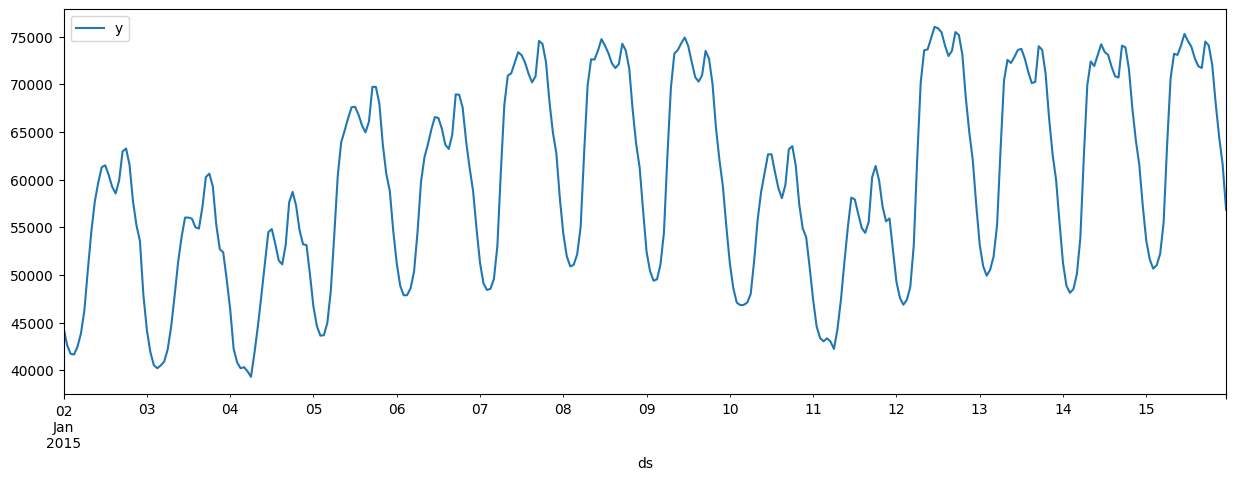

In [67]:
plt = df_train.plot(x="ds", y="y", figsize=(15, 5))

In [69]:
# Create a NeuralProphet model with default parameters
m = NeuralProphet(
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags= 24
)
# Use static plotly in notebooks
m.set_plotting_backend("plotly-resampler")

In [70]:
# Fit the model on the dataset (this might take a bit)
metrics = m.fit(df_train)

Finding best initial lr:   0%|          | 0/215 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [71]:
forecast = m.predict(df_train)
m.plot(forecast)

Predicting: 20it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': 'd1307ee9-3459-4091-8d48-979f4e2c2fd2',
              'x': array([datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 2, 1, 0),
                          datetime.datetime(2015, 1, 2, 2, 0), ...,
                          datetime.datetime(2015, 1, 15, 21, 0),
                          datetime.datetime(2015, 1, 15, 22, 0),
                          datetime.datetime(2015, 1, 15, 23, 0)], dtype=object),
              'y': array([          nan,           nan,           nan, ..., 64061.6015625,
                          61554.03125  , 57156.453125 ])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
          

In [72]:
forecast = m.predict(df_test)
m.plot(forecast)

Predicting: 20it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '39a46cdb-c988-44ee-9720-5874c438afe0',
              'x': array([datetime.datetime(2015, 1, 15, 0, 0),
                          datetime.datetime(2015, 1, 15, 1, 0),
                          datetime.datetime(2015, 1, 15, 2, 0),
                          datetime.datetime(2015, 1, 15, 3, 0),
                          datetime.datetime(2015, 1, 15, 4, 0),
                          datetime.datetime(2015, 1, 15, 5, 0),
                          datetime.datetime(2015, 1, 15, 6, 0),
                          datetime.datetime(2015, 1, 15, 7, 0),
                          datetime.datetime(2015, 1, 15, 8, 0),
                          datetime.datetime(2015, 1, 15, 9, 0),
                          datetime.datetime(2015, 1, 15, 10, 0),
             

In [73]:
residuals = forecast.yhat1 - forecast.y

In [74]:
residuals = residuals.dropna()

<AxesSubplot:>

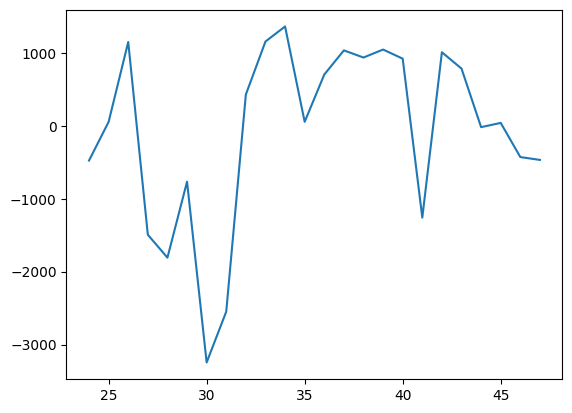

In [75]:
residuals.plot()

In [ ]:
# Create a new dataframe reaching (NUMBER OF TEST) into the future for our forecast, n_historic_predictions also shows historic data
n = len(df_test)
df_future = m.make_future_dataframe(df_train, n_historic_predictions=True, periods=24*7)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

In [ ]:
# Save DataFrame to a CSV file
df.to_csv('load_22-24_model-neuralprophet.csv', index=False)

### Predictions Load

In [3]:
# Function for Predictions
def forecast_nn_loads(df_train,df_test):
    # Create a NeuralProphet model with default parameters
    m = NeuralProphet(
        n_lags = 24,
        weekly_seasonality=True,
        daily_seasonality=True,
        yearly_seasonality=True
    )
    # Fit the model on the dataset (this might take a bit)
    m.fit(df_train, progress= None)
    
    forecast = m.predict(df_test)
    # Calculate residuals
    df_test['yhat'] = forecast['yhat1'].values
    df_test['residuals'] = forecast['y'].values - forecast['yhat1'].values
    return (df_test.dropna())

In [4]:
# Create an empty DataFrame with specified columns
predictions = pd.DataFrame(columns=['ds', 'y', 'yhat', 'residuals'])
# Length for training
length = 365
# First year has 365 days where we use only the last 14 days for training to predict the next day
start = 350
for d in range(start + 1, start + 366):
    print(d)
    df_train = df.iloc[((d - 1) * 24):((length + d) * 24)]
    df_test = df.iloc[((d + length - 1) * 24):((d + length + 365) * 24)]
    forecast = forecast_nn_loads(df_train,df_test)
    # Concatenate df_test to predictions
    predictions = pd.concat([predictions, forecast], ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - /home/rstudio/.local/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)



351


Finding best initial lr:   0%|          | 0/216 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/rstudio/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - /home/rstudio/.local/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/rstudio/.local/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home

In [6]:
# Save DataFrame to a CSV file
predictions.to_csv('load_16_model-neuralprophet.csv', index=False)

<AxesSubplot:>

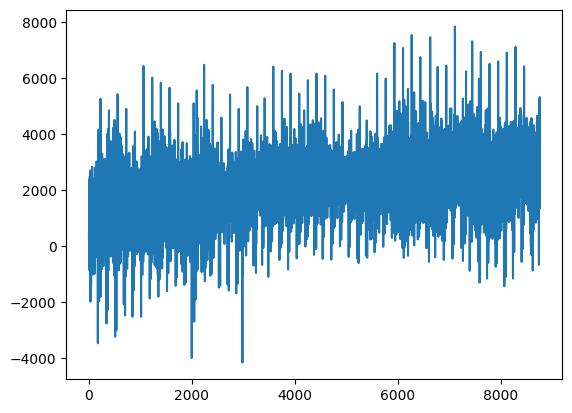

In [7]:
predictions.residuals.plot()

## Energy Peaks

In [6]:
# Get the peaks
peaks_df = df.groupby(df['ds'].dt.date)['y'].max().reset_index()
peaks_df['ds'] = pd.to_datetime(peaks_df['ds'])

In [8]:
d = 1
length = 13

In [15]:
df_train = peaks_df.iloc[(d - 1):(length + d)]
df_test = peaks_df.iloc[(d + length - 1):(d + length + 7)]


In [13]:
# Split the dataframe in a train and test set

# Filter peaks_df for the years 2022 and 2023
peaks_df_train = peaks_df[(peaks_df['ds'].dt.year == 2022) | (peaks_df['ds'].dt.year == 2023)]
peaks_df_test = peaks_df[(peaks_df['ds'].dt.year == 2024)]

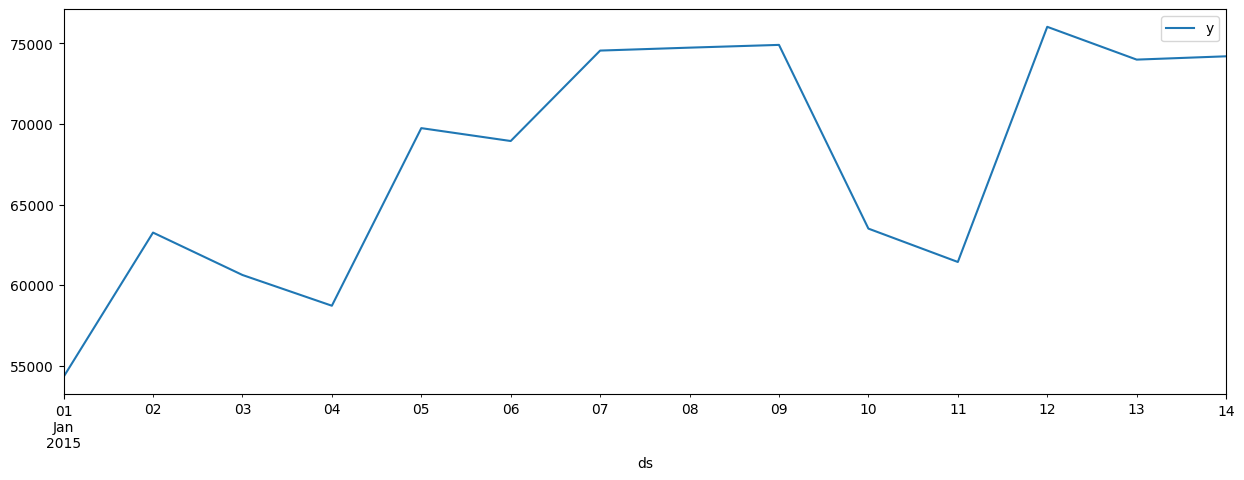

In [10]:
plt = df_train.plot(x="ds", y="y", figsize=(15, 5))

In [11]:
# Create a NeuralProphet model with default parameters
m = NeuralProphet(
    weekly_seasonality=True,
    n_lags= 1
)
# Use static plotly in notebooks
m.set_plotting_backend("plotly-resampler")

In [12]:
# Fit the model on the dataset (this might take a bit)
metrics = m.fit(df_train)

Missing logger folder: /Users/Wohlfarth/Documents/Coding/uni/majwo/predictibality_model_python/lightning_logs


Finding best initial lr:   0%|          | 0/201 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [13]:
forecast = m.predict(df_train)
m.plot(forecast)

Predicting: 1it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': 'd4d732f7-731c-4023-9cf6-6feb02732599',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 3, 0, 0),
                          datetime.datetime(2015, 1, 4, 0, 0),
                          datetime.datetime(2015, 1, 5, 0, 0),
                          datetime.datetime(2015, 1, 6, 0, 0),
                          datetime.datetime(2015, 1, 7, 0, 0),
                          datetime.datetime(2015, 1, 8, 0, 0),
                          datetime.datetime(2015, 1, 9, 0, 0),
                          datetime.datetime(2015, 1, 10, 0, 0),
                          datetime.datetime(2015, 1, 11, 0, 0),
                       

In [16]:
forecast = m.predict(df_test)
m.plot(forecast)

Predicting: 1it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '3e09dffb-51d9-4026-bad3-69d59042591f',
              'x': array([datetime.datetime(2015, 1, 14, 0, 0),
                          datetime.datetime(2015, 1, 15, 0, 0),
                          datetime.datetime(2015, 1, 16, 0, 0),
                          datetime.datetime(2015, 1, 17, 0, 0),
                          datetime.datetime(2015, 1, 18, 0, 0),
                          datetime.datetime(2015, 1, 19, 0, 0),
                          datetime.datetime(2015, 1, 20, 0, 0),
                          datetime.datetime(2015, 1, 21, 0, 0)], dtype=object),
              'y': array([          nan, 74592.4375   , 74866.109375 , 64190.9375   ,
                          61716.21875  , 75609.2421875, 73720.328125 , 75441.6171875])},
             {'

In [20]:
# Create a new dataframe reaching (NUMBER OF TEST) into the future for our forecast, n_historic_predictions also shows historic data
n = len(peaks_df_test)
df_future = m.make_future_dataframe(peaks_df_train, n_historic_predictions=True, periods=n)

# Predict the future
forecast_peaks = m.predict(df_future)

# Visualize the forecast
m.plot(forecast_peaks)

Predicting: 41it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '1e9e6b30-b1ba-49a6-bbdc-5a1e39d35a53',
              'x': array([datetime.datetime(2022, 3, 28, 0, 0),
                          datetime.datetime(2022, 3, 29, 0, 0),
                          datetime.datetime(2022, 3, 30, 0, 0), ...,
                          datetime.datetime(2024, 3, 26, 0, 0),
                          datetime.datetime(2024, 3, 27, 0, 0),
                          datetime.datetime(2024, 3, 28, 0, 0)], dtype=object),
              'y': array([68348.3359375, 69445.5546875, 69639.0703125, ..., 72931.34375  ,
                          73278.859375 , 73027.5546875])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
          

In [25]:
forecast_peaks.iloc[654:]

,ds,y,yhat1,trend,season_weekly
654,2024-01-11,NaN,69010.539062,65470.507812,3540.029053
655,2024-01-12,NaN,68438.468750,65522.675781,2915.791260
656,2024-01-13,NaN,59229.972656,65574.843750,-6344.874512
657,2024-01-14,NaN,55775.316406,65627.015625,-9851.698242
658,2024-01-15,NaN,68028.281250,65679.187500,2349.095215
...,...,...,...,...,...
727,2024-03-24,NaN,59427.152344,69278.851562,-9851.698242
728,2024-03-25,NaN,71680.117188,69331.015625,2349.095215
729,2024-03-26,NaN,72931.343750,69383.187500,3548.154053
730,2024-03-27,NaN,73278.859375,69435.359375,3843.502930


In [26]:
peaks_df_test.iloc[10:]

,ds,y
654,2024-01-11,71991.25
655,2024-01-12,72251.00
656,2024-01-13,64144.50
657,2024-01-14,61171.25
658,2024-01-15,74140.00
...,...,...
727,2024-03-24,51626.75
728,2024-03-25,60386.00
729,2024-03-26,64213.75
730,2024-03-27,62365.25


In [31]:
peaks_df_test.iloc[10:]['y'].values

array([71991.25, 72251.  , 64144.5 , 61171.25, 74140.  , 70982.75,
       73082.  , 71569.5 , 74770.  , 63606.  , 61545.25, 73381.75,
       72494.25, 73122.75, 69740.5 , 69989.75, 58438.75, 55016.  ,
       66610.75, 68755.25, 71291.75, 70875.  , 70086.  , 60136.5 ,
       59600.5 , 69643.75, 71517.25, 71232.  , 68904.  , 69638.75,
       56963.75, 55149.75, 65550.25, 67419.  , 68152.  , 66270.25,
       66222.75, 55900.25, 54884.25, 68046.25, 67726.25, 68279.5 ,
       68519.25, 70075.25, 56961.  , 54381.  , 67946.75, 68442.  ,
       65471.25, 66614.25, 65335.  , 52522.75, 51505.25, 66120.  ,
       68833.75, 65230.  , 65692.5 , 63796.25, 53463.  , 53406.25,
       65035.25, 66313.75, 66218.75, 63515.5 , 64498.5 , 55047.25,
       50497.75, 64774.75, 65603.75, 62809.5 , 63794.75, 62320.75,
       53548.5 , 51626.75, 60386.  , 64213.75, 62365.25, 62337.5 ])

In [32]:
forecast_peaks.iloc[654:]['y'] = peaks_df_test.iloc[10:]['y'].values

WARNING - (py.warnings._showwarnmsg) - /Users/Wohlfarth/Documents/Coding/uni/majwo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [34]:
peaks_df['yhat'] = forecast_peaks['yhat1']

In [35]:
# Visualize the forecast
m.plot(forecast_peaks)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '1565fc45-0c0c-4706-b892-4f4086e18336',
              'x': array([datetime.datetime(2022, 3, 28, 0, 0),
                          datetime.datetime(2022, 3, 29, 0, 0),
                          datetime.datetime(2022, 3, 30, 0, 0), ...,
                          datetime.datetime(2024, 3, 26, 0, 0),
                          datetime.datetime(2024, 3, 27, 0, 0),
                          datetime.datetime(2024, 3, 28, 0, 0)], dtype=object),
              'y': array([68348.3359375, 69445.5546875, 69639.0703125, ..., 72931.34375  ,
                          73278.859375 , 73027.5546875])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
          

In [36]:
# Calculate residuals
peaks_df['residuals'] = peaks_df['y'] - peaks_df['yhat']

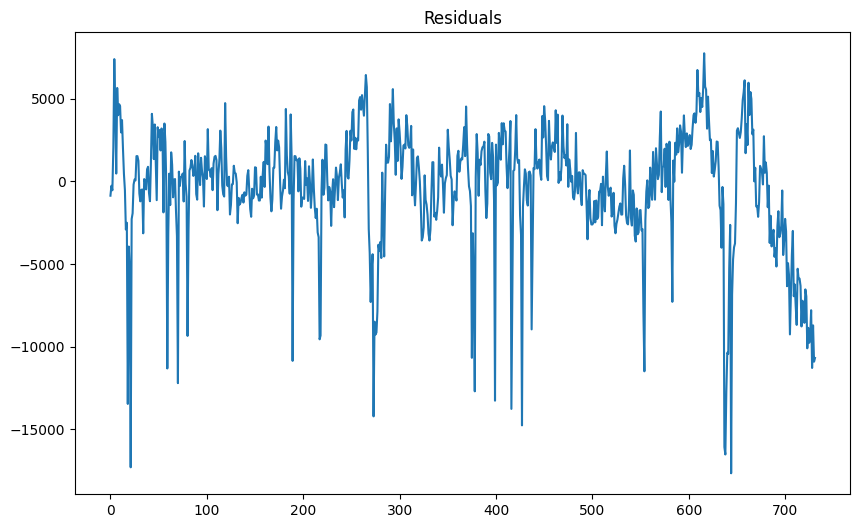

In [39]:
# Plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(peaks_df['residuals'])
plt.title('Residuals')
plt.show()

In [37]:
# Save DataFrame to a CSV file
peaks_df.to_csv('peaks_22-24_model-neuralprophet.csv', index=False)

### Predictions Load Peaks

In [7]:
# Function for Predictions
def forecast_nn_load_peaks(df_train,df_test):
    # Create a NeuralProphet model with default parameters
    m = NeuralProphet(
        weekly_seasonality=True,
        n_lags= 1
    )
    # Fit the model on the dataset (this might take a bit)
    m.fit(df_train, progress= None)
    
    forecast = m.predict(df_test)
    # Calculate residuals
    df_test['yhat'] = forecast['yhat1'].values
    df_test['residuals'] = forecast['y'].values - forecast['yhat1'].values
    return (df_test.dropna())

In [8]:
# Create an empty DataFrame with specified columns
prediction_peaks = pd.DataFrame(columns=['ds', 'y', 'yhat', 'residuals'])
# Length for training
length = 14
# First year has 365 days where we use only the last 14 days for training to predict the next day
start = 350
for d in range(start + 1, start + 366):
    print(d)
    df_train = peaks_df.iloc[(d - 1):(length + d)]
    df_test = peaks_df.iloc[(d + length - 1):(d + length + 1)]
    forecast = forecast_nn_load_peaks(df_train,df_test)
    # Concatenate df_test to predictions_peaks
    predictions_peaks = pd.concat([predictions_peaks, forecast], ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - /home/rstudio/.local/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)



351


Finding best initial lr:   0%|          | 0/201 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/rstudio/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - /home/rstudio/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - /home/rstudio/.local/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/rstudio/.local/lib/python3.10/si

In [ ]:
# Save DataFrame to a CSV file
predictions_peaks.to_csv('peaks_16_model-neuralprophet.csv', index=False)

<AxesSubplot:>

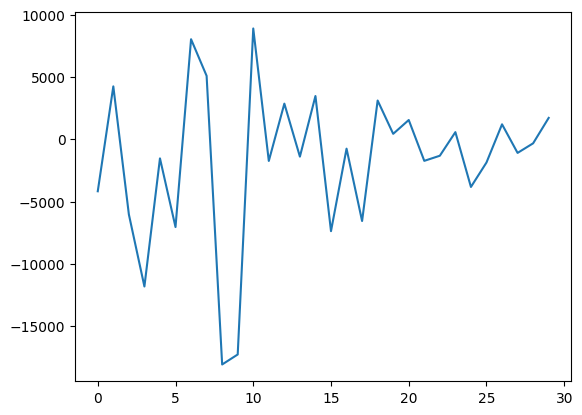

In [23]:
predictions.residuals.plot()